# Import necessary libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Exploratory Data Analysis

In [10]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df.shape

(5572, 5)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


* Unnamed 2, 3 and 4 contain very few information and the rest is null so we remove them
* The column names are not very descriptive so we rename them
* v1 and v2 do not contain any null values

In [13]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True) #dropping unnecessary columns
df.sample(5)

,v1,v2
3616,ham,Sorry sent blank msg again. Yup but trying 2 d...
1841,ham,I am in your office na.
4679,ham,"That's cool he'll be here all night, lemme kno..."
305,ham,Yup... From what i remb... I think should be c...
131,ham,"Dear, will call Tmorrow.pls accomodate."


In [14]:
mapper = {'v1': 'label', 'v2': 'text'} # rename columns
df.rename(columns=mapper, inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df.describe(include='all')

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


we have two unique values in label (spam or ham) => a binary classification problem

In [16]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

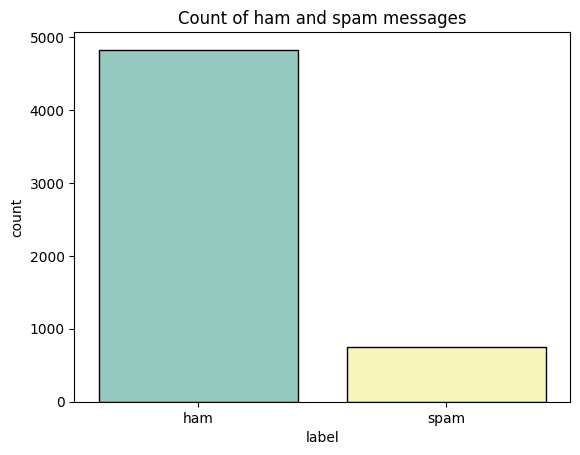

In [17]:
sns.countplot(df, x = 'label', palette='Set3', edgecolor='black')
plt.title("Count of ham and spam messages")
plt.show()

The number of ham messages is way higher than the number of spam messages => unbalanced dataset
This could lead to a biased model that will classify the messages according to the majority class (ham).
We can deal with this by either undersampling the majority class or oversampling the minority class.

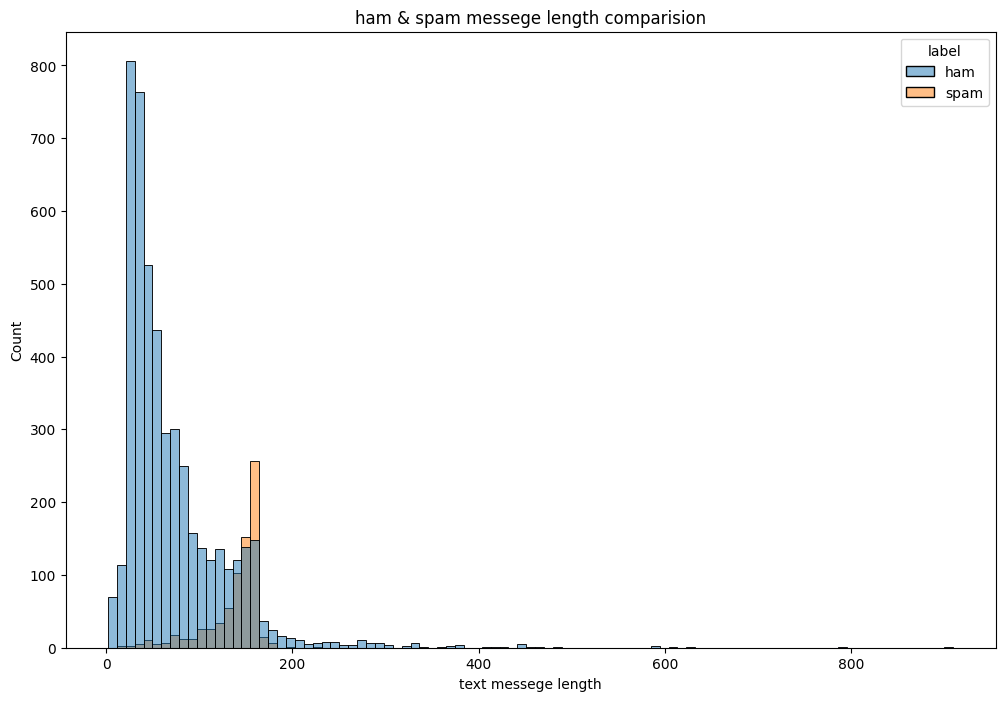

In [18]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=df["text"].str.len(),
    hue=df["label"]
)
plt.title("ham & spam messege length comparision")
plt.xlabel("text messege length")
plt.show()

<b>Keyfindings:</b> <br>
We can see that the ham messages have the longest message of aroung 900 words, however aroung 70% of the ham messages have a length of 100 characters or less.<br>
However, most of the spam messages have a length of 140 characters or more.<br>
=> We can conclude that the spam messages tend to be longer than the ham messages.<br>
=> We can use the length of the message as a feature to help us classify the messages.<br>


In [19]:
#df.label = df.label.map({'ham': 0, 'spam': 1})
#df.head()

# Data Preprocessing

## Undersampling

In [20]:
# Class count
count_ham, count_spam = df.label.value_counts()

# Divide by class
df_ham = df[df['label'] == 'ham']
df_spam = df[df['label'] == 'spam']

In [21]:
# Undersample the ham class and concat the DataFrames of both class
df_ham_under = df_ham.sample(count_spam)
df_under = pd.concat([df_ham_under, df_spam], axis=0)

print('Random under-sampling:')
print(df_under.label.value_counts())

Random under-sampling:
ham     747
spam    747
Name: label, dtype: int64


## Cleaning the text

cleaning_text function:
1. convert to lower case
2. remove punctuation and special characters
3. remove extra spaces
4. remove stopwords
5. join the words back into a string

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stop_words = set(stopwords.words('english')) # sets are more fit to increase the speed of the code

def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Any character out of this a-zA-Z0-9 will be replaced by ''
    text = re.sub(r'\s+', ' ', text)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## Stemming

<b>PorterStemmer</b> uses Suffix Stripping to produce stems. PorterStemmer is known for its simplicity and speed. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' and this is the limitation of the PorterStemmer.

In [24]:
# After cleaning the text we apply stemming to the text
def stemming_text(text):
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text.split()]
    text = ' '.join(text)
    return text

In [25]:
# Example
original = "I HAVE A DATE ON SUNDAY WITH WILL!!,,,"
cleaned = cleaning_text(original)
stemmed = stemming_text(cleaned)
print("Original text:", original)
print("Cleaned text:", cleaned)
print("Stemmed text:", stemmed)

Original text: I HAVE A DATE ON SUNDAY WITH WILL!!,,,
Cleaned text: date sunday
Stemmed text: date sunday


In [26]:
df_under['cleaned_text'] = df_under.text.apply(cleaning_text)
df_under['cleaned_text'] = df_under.cleaned_text.apply(stemming_text)
df_under.head()

,label,text,cleaned_text
5419,ham,I'm at bruce &amp; fowler now but I'm in my mo...,im bruce amp fowler im mom car cant park long ...
1795,ham,I hope your alright babe? I worry that you mig...,hope alright babe worri might felt bit despar ...
2578,ham,Erm. I thought the contract ran out the4th of ...,erm thought contract ran the4th octob
3881,ham,Short But Cute: \Be a good person,short cute good person
4914,ham,We took hooch for a walk toaday and i fell ove...,took hooch walk toaday fell splat graze knee e...


# Extracting feature and target lists

## Target Encoding

In [27]:
le = LabelEncoder()
df_under['label'] = le.fit_transform(df_under['label'])

In [28]:
df_under.head()

,label,text,cleaned_text
5419,0,I'm at bruce &amp; fowler now but I'm in my mo...,im bruce amp fowler im mom car cant park long ...
1795,0,I hope your alright babe? I worry that you mig...,hope alright babe worri might felt bit despar ...
2578,0,Erm. I thought the contract ran out the4th of ...,erm thought contract ran the4th octob
3881,0,Short But Cute: \Be a good person,short cute good person
4914,0,We took hooch for a walk toaday and i fell ove...,took hooch walk toaday fell splat graze knee e...


0: ham <br>
1: spam <br>

## Tokenizing, Sequencing and Padding

<img src="preprocessing_steps.png" alt="Illustrative image" width="50%">

In [29]:
x = df_under.cleaned_text.tolist() # feature list
y = df_under.label.tolist() # target list

This step involves building the vocabulary and assigning unique integer indices to each unique word.

In [30]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x)

In [31]:
word_indices = word_tokenizer.word_index
print("Word Indices:", word_indices)

Word Indices: {'call': 1, 'u': 2, 'free': 3, '2': 4, 'ur': 5, 'txt': 6, 'text': 7, 'get': 8, 'mobil': 9, '4': 10, 'stop': 11, 'repli': 12, 'claim': 13, 'prize': 14, 'send': 15, 'im': 16, 'go': 17, 'new': 18, 'tone': 19, 'servic': 20, 'nokia': 21, 'phone': 22, 'week': 23, 'award': 24, 'pleas': 25, 'contact': 26, 'cash': 27, 'win': 28, 'urgent': 29, 'dont': 30, 'know': 31, 'time': 32, 'day': 33, 'come': 34, 'messag': 35, 'min': 36, 'back': 37, 'want': 38, 'today': 39, 'love': 40, 'collect': 41, 'per': 42, 'custom': 43, 'tc': 44, 'guarante': 45, 'tri': 46, '16': 47, 'ltgt': 48, 'like': 49, 'number': 50, 'chat': 51, '1000': 52, 'good': 53, 'got': 54, '500': 55, 'see': 56, 'take': 57, '18': 58, '1': 59, 'msg': 60, 'show': 61, 'offer': 62, '150': 63, 'draw': 64, 'line': 65, 'receiv': 66, '100': 67, 'everi': 68, 'ok': 69, 'ill': 70, 'latest': 71, 'think': 72, 'voucher': 73, 'r': 74, 'holiday': 75, 'need': 76, '3': 77, 'make': 78, '150ppm': 79, '2000': 80, 'landlin': 81, 'home': 82, 'find': 83

When using 'text_to_sequence', the tokenizer takes input sentences and replaces each word in the sentences with its corresponding integer index based on the learned vocabulary.

In [32]:
sequences = word_tokenizer.texts_to_sequences(x)

We find the longest sentence

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
longest_sentence = max(x, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_sentence))

In [35]:
length_long_sentence

49

Now we pad the tokens with zeros at the end

In [36]:
padded_x = pad_sequences(sequences, length_long_sentence, padding='post')

In [37]:
len(padded_x)

1494

In [38]:
padded_x[0]

array([  16, 1916,  310, 1917,   16,  907,  461,  160,  536,  410,  462,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

# Splitting the data into test, train and validation data

We further split the data into train, test and validation as follows: <br>

*   The size of the training set is 70% of the original
*   The size of the validation set is 15% of the original dataset.
*  The size of the test set is also 15% of the original dataset.



In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(padded_x, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Build the model

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Build the LSTM model

* We define an LSTMModel class that inherts from the nn.Module which is the base class for all neural networks in pytorch.
* The constructor (__init__) will define the parameters of the LSTM:
   + We call for the constructor of the super class (nn.Module)
   + The embedding layer is used to create word embeddings. It maps each word index to a dense vector of embedding_dim dimensions.
   + We create an LSTM layer. The LSTM layer processes the sequences generated by the embedding layer. It takes input of size embedding_dim and produces output of size hidden_dim.
   + We create a fully connected layer. It takes the output from the LSTM layer and maps it to the final output dimension specified by output_dim.
   + We end it with a sigmoid function that will introduce non-linearity to the model and produce the final output of the classification problem.
* We then define a method for the forward pass

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        output = self.sigmoid(output)
        return output

## 2. Convert the train and validation arrays into tensors

In [42]:
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [43]:
'''train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)'''

## 3. Instanciate the model

Choice of the parameters:
* The <b>vocab_size</b> is set to the total number of unique words in the dataset plus one. The additional "+1" is for accommodating the padding token. In natural language processing tasks, it's common to use a special token (usually represented as 0) for padding sequences to ensure they have the same length.
* The <b>embedding_dim</b> represents the dimensionality of the word embeddings. For smaller datasets or less complex tasks, you can start with a lower value (e.g., 50).For larger datasets or more complex language patterns, you might try a higher value (e.g., 100 to 300).
* It's common to set <b>hidden_dim</b> equal to or greater than embedding_dim. It represents the number of units or dimensions in the hidden state of the LSTM layer.
* The <b>output_dim</b> represents the dimensionality of the final output. In this case, it's set to 1 because it's a binary classification problem (spam or not spam)


In [44]:
vocab_size = len(word_indices) + 1
embedding_dim = 100
hidden_dim = 100
output_dim = 1
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

## 4. Define the optimazer and the loss function

Since we have a binary classification problem, we use Binary Cross Entropy as loss function.

In [45]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Define the training loop

We mount the model and the tensor on the GPU so that the training loop will be executed on the GPU

In [46]:
model.to(device)

LSTMModel(
  (embedding): Embedding(4171, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

The training loop works as follows:
* we set the number of epoch to 1000 (it's the number of times the model will iterate over the entire training set)
* train_loss is a list that will store the training losses at a regular interval
* For each epoch:
  + we train the model (model.train())
  + perform a forward pass and get the model prediction for the training data (output)
  + Calculate the cross entropy (loss function) between the predictions and the actual labels
  + zeros the gradients of the model parameter before performing a backward pass
  + perform a backward pass
  + Every 10 epoch compute the total loss
  + Every 50 epochs start validating the model

In [49]:
num_epochs = 1000
train_losses = []  # To store training losses for plotting

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Forward pass
    outputs = model(X_train_tensor)

    # Compute loss
    loss = criterion(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    # Print training information
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        train_losses.append(total_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}')
        total_loss = 0.0

    # Validation evaluation
    if (epoch + 1) % 50 == 0:  # Evaluate on validation every 50 epochs
        model.eval()
        with torch.no_grad(): #Temporarily disables gradient computation during validation to save memory.
            val_outputs = model(X_val_tensor)
            val_predictions = (val_outputs.squeeze() > 0.5).cpu().numpy()

        # Evaluate metrics on validation set
        accuracy = accuracy_score(y_val, val_predictions)
        precision = precision_score(y_val, val_predictions)
        recall = recall_score(y_val, val_predictions)
        f1 = f1_score(y_val, val_predictions)

        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Epoch 10/1000, Loss: 0.6943
Epoch 20/1000, Loss: 0.6934
Epoch 30/1000, Loss: 0.6930
Epoch 40/1000, Loss: 0.6929
Epoch 50/1000, Loss: 0.6929
Validation Accuracy: 0.5000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/1000, Loss: 0.6928
Epoch 70/1000, Loss: 0.6927
Epoch 80/1000, Loss: 0.6927
Epoch 90/1000, Loss: 0.6927
Epoch 100/1000, Loss: 0.6926
Validation Accuracy: 0.5000
Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch 110/1000, Loss: 0.6926
Epoch 120/1000, Loss: 0.6926
Epoch 130/1000, Loss: 0.6926
Epoch 140/1000, Loss: 0.6926
Epoch 150/1000, Loss: 0.6925
Validation Accuracy: 0.5000
Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch 160/1000, Loss: 0.6925
Epoch 170/1000, Loss: 0.6925
Epoch 180/1000, Loss: 0.6925
Epoch 190/1000, Loss: 0.6925
Epoch 200/1000, Loss: 0.6925
Validation Accuracy: 0.5000
Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch 210/1000, Loss: 0.6925
Epoch 220/1000, Loss: 0.6925
Epoch 230/1000, Loss: 0.6925
Epoch 240/1000, Loss: 0.6925
Epoch 250/1000, Loss: 0.6922
Validation Accuracy: 0.5045
Precision: 0.5022, Recall: 1.0000, F1 Score: 0.6687
Epoch 260/1000, Loss: 0.6925
Epoch 270/1000, Loss: 0.6925
Epoch 280/1000, Loss: 0.6924
Epoch 290/1000, L

## 6. Evaluation on test data

In [50]:
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [52]:
X_test_tensor = X_test_tensor.to(device)
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs.squeeze() > 0.5).cpu().numpy()

accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Test Accuracy: 0.8800
Precision: 0.8244, Recall: 0.9643, F1 Score: 0.8889


Confusion Matrix:
[[ 90  23]
 [  4 108]]


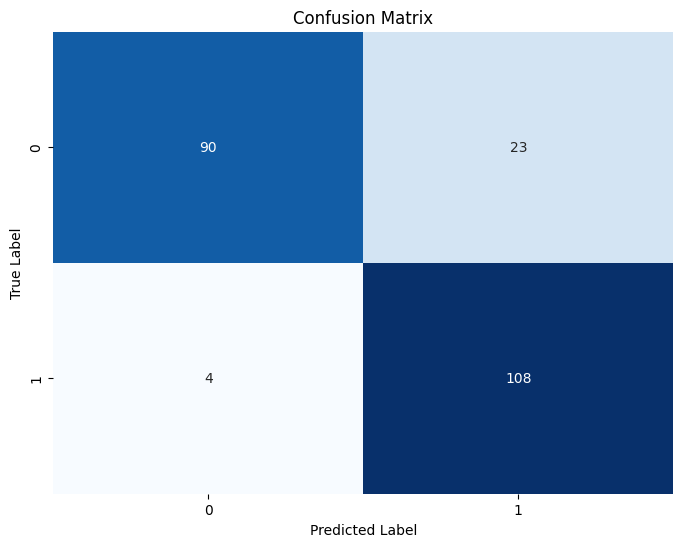

In [53]:
# Print and Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()